In [27]:
from google.cloud import language_v1
import os
import re

In [28]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = './cueback-app-e91f3f8c0155.json'

In [29]:
client = language_v1.LanguageServiceClient()

In [30]:
def extract_entity(text):
    global client
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    return client.analyze_entities(request={'document': document})

def extract_sentiment(text):
    global client
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    return client.analyze_sentiment(request={'document': document})

In [42]:
def entity_sentiment(text):
    if len(text.split()) > 0:
        r1 = extract_entity(text)
        entities_sentiment={}
        for e in r1.entities:
            if str(e.type_) in ['Type.PERSON', 'Type.ORGANIZATION', 'Type.LOCATION', 'Type.DATE']:
                sentiments = []
                for mention in e.mentions:
                    try:
                        sentences = re.findall(r"([^.]*?"+mention.text.content+"[^.]*\.)",text)  
                        for s in sentences:
                            sentiment = extract_sentiment(s)
                            sentiments.append(sentiment.document_sentiment.score)
                    except:
                        pass
                if len(sentiments) != 0:
                    entities_sentiment[e.name] = sum(sentiments) / len(sentiments)
        entities_sentiment = dict(sorted(entities_sentiment.items(), key=lambda item: item[1], reverse=True))
        print(entities_sentiment)
        return entities_sentiment

# Aggregated Test using data from the App pilot

In [33]:
import pandas as pd 
from tqdm import tqdm

In [34]:
tqdm.pandas()

/Users/mo/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [35]:
test_df = pd.read_csv('data/platform data.csv')
test_df.columns

Index(['Unnamed: 0', 'Title', 'Len', 'Ed', 'Woody', 'Photo'], dtype='object')

In [36]:
len(test_df)

14

## Analysis

In [41]:
test_df['len_insights'] = test_df['Len'].apply(entity_sentiment)

{'DJ Trainees': 0.800000011920929, 'Steve Stagnero': 0.6000000238418579, '1971': 0.2500000037252903, 'KCPR': 0.22000000327825547, 'parts': 0.10000000149011612, 'Format Sheets': 0.02500000037252903, 'few': 0.0, 'The Lounge': 0.0, 'DJ trainees': -0.10000000149011612, 'world': -0.10000000149011612, 'Blood, Sweat & Tears': -0.10000000149011612, 'Beach Boys': -0.10000000149011612, 'The Who': -0.10000000149011612, 'Andy Williams': -0.10000000149011612, 'Winter Quarter': -0.20000000298023224, '1972': -0.20000000298023224, 'anyone': -0.4000000059604645}
{'radio station': 0.10000000149011612, 'student': 0.10000000149011612, 'everyone': 0.10000000149011612, 'DJ trainees': 0.10000000149011612, 'Jim Stueck': 0.0, 'Alan Holmes': 0.0, 'studio': 0.0, 'staff': 0.0, 'facilities': 0.0, 'KCPR': 0.0, 'Woody Goulart': 0.0}
{'collaborator': 0.4000000059604645, 'Anyone': 0.4000000059604645, 'Radio Hill': 0.0, 'government': 0.0, 'station': 0.0, 'transmitter facilities': 0.0, 'Emergency Broadcast System': 0.0,

{'master control room': 0.30000001192092896, 'radio station': 0.20000000298023224, 'Bill Gurzi': 0.15000000409781933, 'station': 0.15000000223517418, '1971': 0.13333333532015482, 'Room 202': 0.10000000149011612, 'studios': 0.10000000149011612, 'offices': 0.10000000149011612, 'Master Control Room': 0.10000000149011612, 'Craig Hines': 0.10000000149011612, 'KCPR': 0.06666667014360428, 'KSLY': 0.06666667014360428, 'William R. Gurzi': 0.0, 'studio': -0.05000000074505806, 'Room 201': -0.10000000149011612, '1970': -0.10000000149011612, '1973': -0.20000000298023224}
{'campus carpentry department': 0.8999999761581421, 'Bill Gurzi': 0.7714285509926933, 'factory floor': 0.699999988079071, 'Mid State Electronics': 0.6000000238418579, 'side': 0.5999999940395355, "Ed O'Brien": 0.5999999841054281, 'studio': 0.44999998807907104, 'control room': 0.42500000074505806, 'board': 0.3799999952316284, 'campus': 0.29999998211860657, 'Marty Hijmans': 0.24615384065187895, 'Sparta A-20': 0.20000000298023224, 'Sac

In [46]:
test_df['Ed'] = test_df['Ed'].astype(str)
test_df['ed_insights'] = test_df['Ed'].apply(entity_sentiment)

{'engineering student': 0.800000011920929, 'KSAN': 0.800000011920929, 'Bay Area': 0.800000011920929, 'KSJO': 0.800000011920929, 'station': 0.4000000059604645, 'archies': 0.30000001192092896, '1970': 0.10000000149011612, '1971': 0.10000000149011612, 'Steve Lamont': 0.0, 'freshman': 0.0, "Ed O'Brien": 0.0, 'Cal Poly': 0.0, 'competitor': 0.0, 'KCPR': 0.0, 'AM station downtown': 0.0, 'photo timer': 0.0, 'KSLY': 0.0, 'CraLab': 0.0, 'Alan Stone': 0.0, 'audience': 0.0, 'Bobby Sherman': 0.0, 'DJ': -0.09999999701976776, 'hallways': -0.10000000149011612, 'staff': -0.10000000149011612, 'Graphic Arts Bldg': -0.10000000149011612, 'program plantation': -0.20000000298023224, 'dot': -0.20000000670552254, 'rap artist': -0.30000001192092896, 'QRK': -0.30000001192092896, 'heaven': -0.4000000059604645, 'DJs': -0.44999999552965164, 'beginner DJs': -0.699999988079071, 'control room': -0.699999988079071}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [47]:
test_df['Woody'] = test_df['Ed'].astype(str)
test_df['woody_insights'] = test_df['Woody'].apply(entity_sentiment)

{'engineering student': 0.800000011920929, 'KSAN': 0.800000011920929, 'Bay Area': 0.800000011920929, 'KSJO': 0.800000011920929, 'station': 0.4000000059604645, 'archies': 0.30000001192092896, '1970': 0.10000000149011612, '1971': 0.10000000149011612, 'Steve Lamont': 0.0, 'freshman': 0.0, "Ed O'Brien": 0.0, 'Cal Poly': 0.0, 'competitor': 0.0, 'KCPR': 0.0, 'AM station downtown': 0.0, 'photo timer': 0.0, 'KSLY': 0.0, 'CraLab': 0.0, 'Alan Stone': 0.0, 'audience': 0.0, 'Bobby Sherman': 0.0, 'DJ': -0.09999999701976776, 'hallways': -0.10000000149011612, 'staff': -0.10000000149011612, 'Graphic Arts Bldg': -0.10000000149011612, 'program plantation': -0.20000000298023224, 'dot': -0.20000000670552254, 'rap artist': -0.30000001192092896, 'QRK': -0.30000001192092896, 'heaven': -0.4000000059604645, 'DJs': -0.44999999552965164, 'beginner DJs': -0.699999988079071, 'control room': -0.699999988079071}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [53]:
test_df.to_csv('analyzed platform data.csv')

## Aggregation

In [74]:
entities_dict = {}
dfs=[]
def get_dfs(d):
    global dfs
    entities_df = pd.DataFrame.from_dict(d, orient='index').reset_index().rename({'index':'entity',0:'sentiment'},axis=1)
    dfs.append(entities_df)
    
test_df['len_insights'].apply(get_dfs)

entities_df = pd.concat(dfs)

In [89]:
agg_entities_df = entities_df.groupby('entity').agg(['mean', 'count']).reset_index()
agg_entities_df.columns = agg_entities_df.columns.droplevel(0)
agg_entities_df.rename({'': 'entity','mean':'sentiment'},axis=1, inplace=True)
agg_entities_df.sort_values('sentiment', ascending=False , inplace=True)
count_entities_df = agg_entities_df.sort_values('count', ascending=False )

# Visuals

Top 10 Entities by sentiment

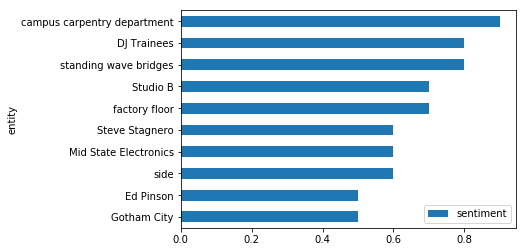

In [96]:
plt= agg_entities_df.head(10).sort_values('sentiment').plot.barh(x='entity', y='sentiment')


Top 10 Entities by count

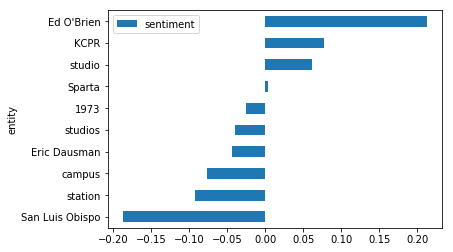

In [98]:
count_entities_df.head(10).sort_values('sentiment').plot.barh(x='entity', y='sentiment')

Least 10 Entities by sentiment

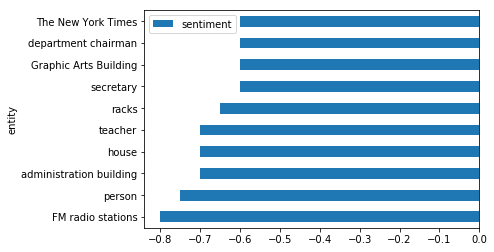

In [99]:
count_entities_df.sort_values('sentiment').head(10).plot.barh(x='entity', y='sentiment')